In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys

# Define style for plots
selectedFont = {'fontname':'DejaVu Sans', 'size':14}

def progressBar(value, endvalue, bar_length=20):

        percent = float(value) / endvalue
        arrow = '-' * int(round(percent * bar_length)-1) + '>'
        spaces = ' ' * (bar_length - len(arrow))

        sys.stdout.write("\rStatus: [{0}] {1}%".format(arrow + spaces, int(round(percent * 100))))
        sys.stdout.flush()

In [2]:
# Function to calculate self-mutual inductance
def calculateInductanceOneForLoop(x, y, polarities, Ns, Ds, strandToHalfTurn, flag_strandCorrection=0, flag_sumTurnToTurn=1, flag_writeOutput=0):
    # Check inputs
    if np.size(x)!=np.size(y):
        raise Exception('Variables x and y must have the same length.')
    if np.size(x)!=np.size(polarities):
        raise Exception('Variables x and polarities must have the same length.')
    if np.size(x)!=np.size(Ds):
        raise Exception('Variables x and Ds must have the same length.')
    if np.size(x)!=np.size(strandToHalfTurn):
        raise Exception('Variables x and strandToHalfTurn must have the same length.')
    if np.size(x)!=np.sum(Ns):
        raise Exception('The sum of the elements of vector Ns must be equal to the number of elements in vector x.')
    if np.size(Ns)<np.max(strandToHalfTurn):
        raise Exception('The variable strandToHalfTurn cannot contain elements higher than the number of half-turns, i.e. the length of Ns.')
    if np.size(Ns)>np.size(np.unique(strandToHalfTurn)):
        print('Warning - ' + 'The variable strandToHalfTurn must assign strands to all half-turns.')
    # If needed, assign default values
#     if isfield(functionOptions,'strandToCoilSection')
#         strandToCoilSection=functionOptions.strandToCoilSection;
#         flag_inductanceCoilSections=1;
#         if size(x)==size(strandToCoilSection')
#             strandToCoilSection=strandToCoilSection';
#         end
#         % Check input    
#         if size(x)~=size(strandToCoilSection)
#             error('Variables x and strandToCoilSection must have the same length.')
#         end
#     else
#         strandToCoilSection=NaN;
#         flag_inductanceCoilSections=0;
#     end

    # Define constants
    veryLow = 1e-12;
    mu0 = 4*np.pi/10**7;

    # Calculate number of strands and half-turns
    nStrands=np.size(x);
    nHalfTurns=np.size(Ns);
    nTurns=int(np.size(Ns)/2);
    nCoilSections=np.max(strandToCoilSection);

    # Only consider the sign of the vector with current polarities
    polarities = np.sign(polarities);

    # Calculate self-mutual inductance between strands    
    oneTwentiethStrands = np.round(nStrands/20) # This is used only to show progress during the calculation
    print('Self-mutual inductance between strands - Calculation started')
    if flag_strandCorrection==0:
        print('Calculation does not include correction for strand diameter.')
        M_strands = np.zeros((nStrands,nStrands))
        # Calculate mutual inductances between strands
        for p1 in range(nStrands):
            if p1 % oneTwentiethStrands == 0:
#                 print('Progress: ' + str(p1) + '/' + str(nStrands))
                progressBar(p1, nStrands, bar_length=20)
            M_strands[p1,:]=-np.sign(polarities[p1])/Ns[strandToHalfTurn[p1]-1]*np.sign(polarities[:])/Ns[strandToHalfTurn[:]-1]*mu0/2/np.pi*np.log((((x[p1]-x[:])**2+(y[p1]-y[:])**2)**.5+veryLow)/Ds[:])
        # Correct the elements on the diagonal
        idxDiagStrands = np.diag_indices(nStrands)
        M_strands[idxDiagStrands]=mu0/np.pi/8/Ns[strandToHalfTurn[:]-1]
    else:
        raise Exception('Calculation including correction for strand diameter is currently not supported.')
#         print('Calculation includes correction for strand diameter.')
#         # Initialization
#         M_strands = np.zeros((nStrands,nStrands))
#         # Calculate mutual inductances between strands
#         for p1 in range(nStrands):
#             if p1 % oneTwentiethStrands == 0:
#                 print('Progress: ' + str(p1) + '/' + str(nStrands))
#             M_strands[p1,:]=-np.sign(polarities[p1])/Ns[strandToHalfTurn[p1]-1]*np.sign(polarities[:])/Ns[strandToHalfTurn[:]-1]*mu0/2/np.pi*np.log((((x[p1]-x[:])**2+(y[p1]-y[:])**2)**.5-Ds[:]+veryLow)/Ds[:])
#         # Correct the elements on the diagonal
#         idxDiagStrands = np.diag_indices(nStrands)
#         M_strands[idxDiagStrands]=mu0/np.pi/8/Ns[strandToHalfTurn[:]-1]
    progressBar(1,1, bar_length=20)
    print('')
    print('Self-mutual inductance between strands - Calculation finished')

    # Calculate total magnet self-inductance
    L_mag0 = np.sum(M_strands)

    # Calculate self-mutual inductance between half-turns
    M_halfTurns = np.empty((nHalfTurns,nHalfTurns))
    oneTwentiethHalfTurns = np.round(nHalfTurns/20) # This is used only to show progress during the calculation
    print('Self-mutual inductance between half-turns - Calculation started')
    for ht1 in range(nHalfTurns):
        idxHT1 = np.where(strandToHalfTurn==ht1+1)
        if ht1 % oneTwentiethHalfTurns == 0:
            progressBar(ht1, nHalfTurns, bar_length=20)
    #          print('Progress: ' + str(ht1) + '/' + str(nHalfTurns))
        for ht2 in range(nHalfTurns):
            idxHT2 = np.where(strandToHalfTurn==ht2+1)
            M_halfTurns[ht1,ht2] = np.sum(M_strands[idxHT1[0][:,None],idxHT2[0]])
    progressBar(1,1, bar_length=20)
    print('')
    print('Self-mutual inductance between half-turns - Calculation finished')
    
    # Calculate self-mutual inductance between turns
    # THIS ASSUMES THAT THE SECOND HALF OF THE HALF-TURNS ARE THE RETURN LINES OF THE FIRST HALF
    if flag_sumTurnToTurn==1:
        halfTurnToTurn=np.tile(np.arange(1,nTurns+1),2);
        M_turns = np.empty((nTurns,nTurns))
#         print('Self-mutual inductance between turns - Calculation started')
        for t1 in range(nTurns):
            idxT1 = np.where(halfTurnToTurn==t1+1)
            for t2 in range(nTurns):
                idxT2 = np.where(halfTurnToTurn==t2+1)
                M_turns[t1,t2] = np.sum(M_halfTurns[idxT1[0][:,None],idxT2[0]])
        print('Self-mutual inductance between turns - Calculation finished')
    else:
        raise Exception('The only supported option is to flag_sumTurnToTurn to 1: Consider that the second half of the half-turns are the return lines of the first half.')
        
    # Calculate self-mutual inductance between defined coil sections
    M_coilSections = np.empty((nCoilSections,nCoilSections))
#     print('Self-mutual inductance between coil sections - Calculation started')
    for cs1 in range(nCoilSections):
        idxCs1 = np.where(strandToCoilSection==cs1+1)
        for cs2 in range(nCoilSections):
            idxCs2 = np.where(strandToCoilSection==cs2+1)
            M_coilSections[cs1,cs2] = np.sum(M_strands[idxCs1[0][:,None],idxCs2[0]])
    print('Self-mutual inductance between coil sections - Calculation finished')

    # Write output file (optional)
    if flag_writeOutput==1:
        outputFileName = 'SMIC_outputCalculatedInductances.txt'
        file_out = open(outputFileName, "w") ## 'w' overwrites file
        file_out.write("%s\n" %('Self- and mutual inductances per unit length between each turn [H/m]'))
        for t1 in range(nTurns):
            for t2 in range(nTurns):
                file_out.write("%12.9e, " %(M_turns[t1,t2]))
            file_out.write("%s\n" %(''))

        file_out.write("%s\n" %(''))
        file_out.write("%s\n" %('Self- and mutual inductances per unit length between each coil section [H/m]'))
        for cs1 in range(nCoilSections):
            for cs2 in range(nCoilSections):
                file_out.write("%12.9e, " %(M_coilSections[cs1,cs2]))
            file_out.write("%s\n" %(''))

        file_out.write("%s\n" %(''))
        file_out.write("%s\n" %('Total self-inductance per unit length [H/m]'))
        file_out.write("%12.9e" %(L_mag0))
        file_out.close()
        print('Output file written: ' + outputFileName + '.')

    return M_halfTurns, M_turns, M_coilSections, L_mag0

Total number of strands = 16000
Total number of half-turns = 400
Total number of turns = 200


(-0.11668959974161837,
 0.11668959974161837,
 -0.1175718117791814,
 0.11757181177918134)

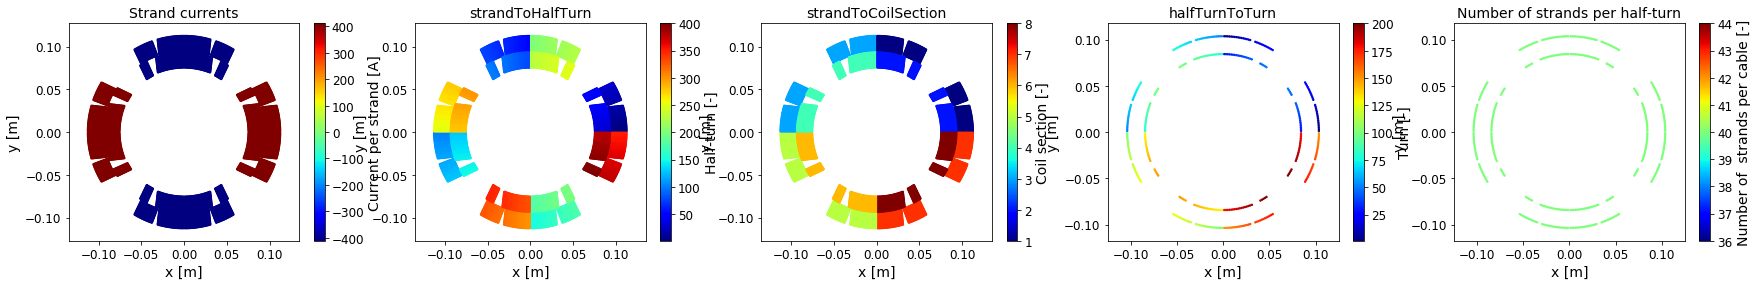

In [5]:
#Acquire inputs
fileName = 'inputSMIC_MQXF_V2.csv'
headerLines = 0

strandToCoilSection = np.array([])
strandToHalfTurn = np.array([])
x = []
y = []
I = []
Ds = []
Ns = []


file = open(fileName, "r")
fileContent = file.read()

# separate rows
fileContentByRow = fileContent.split("\n")

for index in range(len(fileContentByRow)-1):
    if index>headerLines:
        fc = fileContentByRow[index]
        row = fc.split(',')
#         print(index)
#         print(row)
        strandToCoilSection = np.hstack([strandToCoilSection,int(row[0])])
        strandToHalfTurn = np.hstack([strandToHalfTurn,int(row[1])])
        x = np.hstack([x,float(row[2])])
        y = np.hstack([y,float(row[3])])
        I = np.hstack([I,float(row[4])])
        Ds = np.hstack([Ds,float(row[5])])

# print(strandToCoilSection)
# print(strandToHalfTurn)
# print(x)
# print(y)
# print(I)
# print(Ds)

nStrands = len(strandToCoilSection)
polarities = np.sign(I);
nHalfTurns = int(np.max(strandToHalfTurn));
nTurns = int(nHalfTurns/2)
for ht in range(1,nHalfTurns+1):
    #Ns =sum(strandToHalfTurn==ht);
    Ns = np.hstack([ Ns, np.size(np.where(strandToHalfTurn==ht)) ]) # Number of strands in each half-turn

strandToCoilSection = np.int_(strandToCoilSection)
strandToHalfTurn = np.int_(strandToHalfTurn)
halfTurnToTurn=np.tile(np.arange(1,nTurns+1),2);

# Average half-turn positions
x_ave = []
y_ave = []
for ht in range(1,nHalfTurns+1):
    x_ave = np.hstack([ x_ave, np.mean( x[np.where(strandToHalfTurn==ht)] )])
    y_ave = np.hstack([ y_ave, np.mean( y[np.where(strandToHalfTurn==ht)] )])
    
print('Total number of strands = ' + str(nStrands))
print('Total number of half-turns = ' + str(nHalfTurns))
print('Total number of turns = ' + str(nTurns))

# Plot
f = plt.figure(figsize=(30,4))
plt.subplot(1, 5, 1 )
plt.scatter(x, y, s=2, c=I)
plt.xlabel('x [m]',**selectedFont)
plt.ylabel('y [m]',**selectedFont)
plt.title('Strand currents',**selectedFont)
plt.set_cmap('jet')
cbar = plt.colorbar()
cbar.set_label('Current per strand [A]',**selectedFont)
#plt.grid(True)
plt.rcParams.update({'font.size': 12})
plt.axis('equal')

plt.subplot(1, 5, 2 )
plt.scatter(x, y, s=2, c=strandToHalfTurn)
plt.xlabel('x [m]',**selectedFont)
plt.ylabel('y [m]',**selectedFont)
plt.title('strandToHalfTurn',**selectedFont)
plt.set_cmap('jet')
cbar = plt.colorbar()
cbar.set_label('Half-turn [-]',**selectedFont)
#plt.grid(True)
plt.rcParams.update({'font.size': 12})
plt.axis('equal')

plt.subplot(1, 5, 3 )
plt.scatter(x, y, s=2, c=strandToCoilSection)
plt.xlabel('x [m]',**selectedFont)
plt.ylabel('y [m]',**selectedFont)
plt.title('strandToCoilSection',**selectedFont)
plt.set_cmap('jet')
cbar = plt.colorbar()
cbar.set_label('Coil section [-]',**selectedFont)
#plt.grid(True)
plt.rcParams.update({'font.size': 12})
plt.axis('equal')


plt.subplot(1, 5, 4 )
plt.scatter(x_ave, y_ave, s=2, c=halfTurnToTurn)
plt.xlabel('x [m]',**selectedFont)
plt.ylabel('y [m]',**selectedFont)
plt.title('halfTurnToTurn',**selectedFont)
plt.set_cmap('jet')
cbar = plt.colorbar()
cbar.set_label('Turn [-]',**selectedFont)
#plt.grid(True)
plt.rcParams.update({'font.size': 12})
plt.axis('equal')

plt.subplot(1, 5, 5 )
plt.scatter(x_ave, y_ave, s=2, c=Ns)
plt.xlabel('x [m]',**selectedFont)
plt.ylabel('y [m]',**selectedFont)
plt.title('Number of strands per half-turn',**selectedFont)
plt.set_cmap('jet')
cbar = plt.colorbar()
cbar.set_label('Number of  strands per cable [-]',**selectedFont)
#plt.grid(True)
plt.rcParams.update({'font.size': 12})
plt.axis('equal')


In [4]:
# Self-mutual inductance calculation
flag_strandCorrection = 0
flag_sumTurnToTurn = 1
flag_writeOutput = 1

calculatedM = calculateInductanceOneForLoop(x, y, polarities, Ns, Ds, strandToHalfTurn, flag_strandCorrection, flag_sumTurnToTurn, flag_writeOutput)
M_halfTurns = calculatedM[0]
M_turns = calculatedM[1]
M_coilSections = calculatedM[2]
L_mag0 = calculatedM[3]

print('')
print('Total self-inductance per unit length: ' + str(L_mag0) + ' H/m')


Self-mutual inductance between strands - Calculation started
Calculation does not include correction for strand diameter.
Status: [------------------->] 100%
Self-mutual inductance between strands - Calculation finished
Self-mutual inductance between half-turns - Calculation started
Status: [------------------->] 100%
Self-mutual inductance between half-turns - Calculation finished
Self-mutual inductance between turns - Calculation finished
Self-mutual inductance between coil sections - Calculation finished
Output file written: SMIC_outputCalculatedInductances.txt.

Total self-inductance per unit length: 0.008115936056900091 H/m
